<img src="images/dask_horizontal.svg" align="right" width="30%">

# Table of Contents
* [DataFrame](#DataFrame)
	* [Setup](#Setup)
	* [Load Data from CSVs and inspect the dask graph](#Load-Data-from-CSVs-and-inspect-the-dask-graph)
		* [`dask.dataframe.read_csv`](#dask.dataframe.read_csv)
		* [Exercise: Inspect dask graph](#Exercise:-Inspect-dask-graph)
	* [How does this compare to Pandas?](#How-does-this-compare-to-Pandas?)
		* [Features and Size](#Features-and-Size)
		* [Speed](#Speed)
		* [Exercise: Recall and use Pandas API](#Exercise:-Recall-and-use-Pandas-API)
		* [Exercise](#Exercise)
	* [Limitations](#Limitations)
		* [What doesn't work?](#What-doesn't-work?)
		* [What definitely works?](#What-definitely-works?)


In [1]:
import distributed
client = distributed.Client()

<img src="images/pandas_logo.png" align="right" width="40%">

# DataFrame

In this section we use `dask.dataframe` to automatically build and execute dask graphs which process large volumes of CSV files automatically.

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

**Main Take-aways**

1.  Dask.dataframe should be familiar to Pandas users
2.  The index grows to include partitions, which are important for efficient queries

## Setup

We create artifical data.

In [2]:
from prep import accounts_csvs
accounts_csvs(3, 1000000, 500)

import os
filename = os.path.join('data', 'accounts.*.csv')

## Load Data from CSVs and inspect the dask graph

In this section we'll use `dask.dataframe` to read in many CSV files at once and compute their total length, using a more Pandas-like interface rather than by playing with iterables and dictionaries manually.

### `dask.dataframe.read_csv`

This works just like `pandas.read_csv`, except on multiple csv files at once.

In [3]:
filename

'data/accounts.*.csv'

In [4]:
import dask.dataframe as dd
df = dd.read_csv(filename)
# load and count number of rows
%time len(df)

CPU times: user 61.2 ms, sys: 27.4 ms, total: 88.6 ms
Wall time: 1.24 s


3000000

### Exercise: Inspect dask graph

Dask `DataFrame` copies a subset of the Pandas API.  

However unlike Pandas, operations on dask.dataframes don't trigger immediate computation, instead they add key-value pairs to an underlying dask graph. Recall that in the diagram below, circles are operations and rectangles are results.

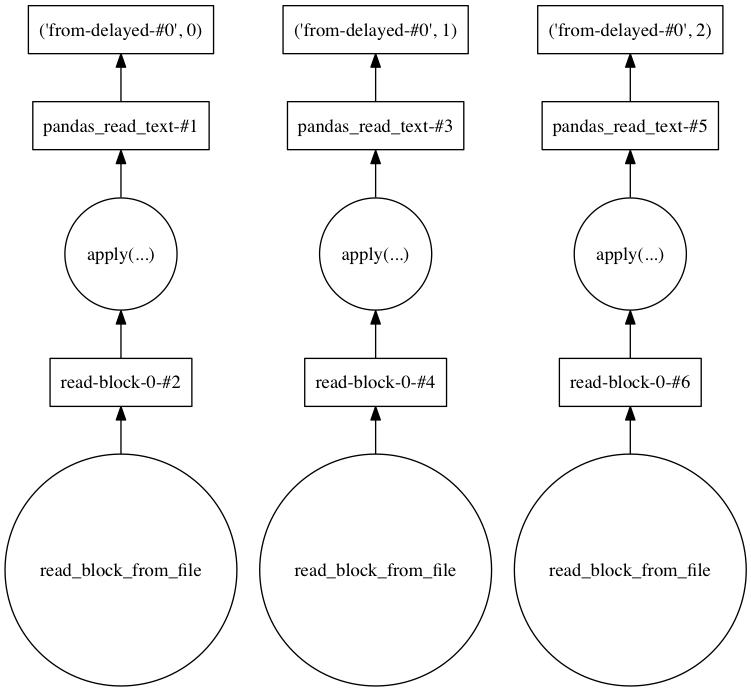

In [5]:
df.visualize()

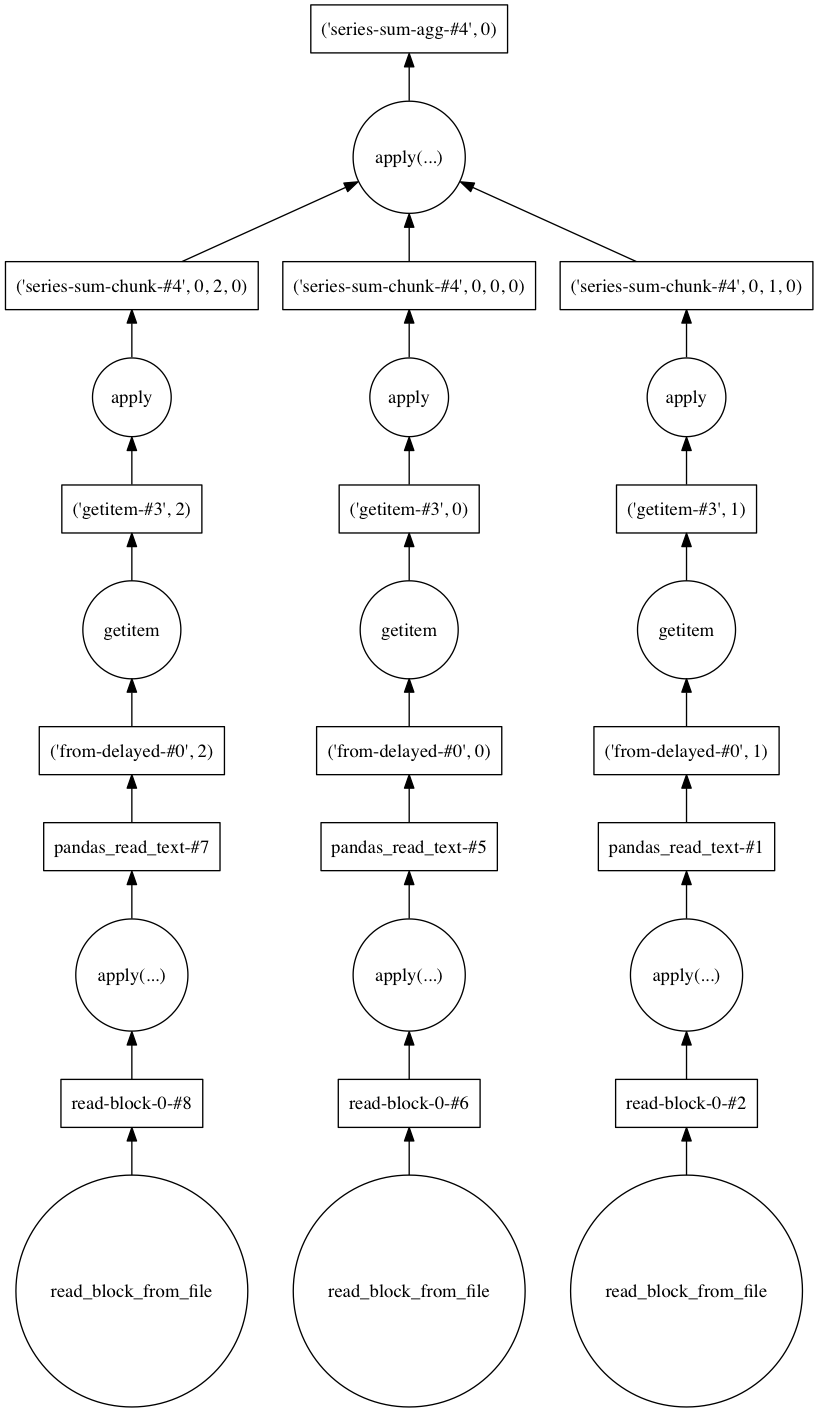

In [6]:
df.amount.sum().visualize()

Above we see graphs corresponding to a call to `dd.read_csv` and `df.amount.sum()` on the result.  

Below we see the resulting computations as dictionaries.  You'll note that these dictionaries are certainly more complex than what we built by hand. However if you look closely then you'll see all of the familiar elements of `pd.read_csv` and the filenames. The same procedure could be created using `delayed` with appropriate for-loops, but here everything is handled automatically for us. 

Try changing around the expression `df.amount.sum()` and see how the dictionary and graph change.  Explore a bit with the Pandas syntax that you already know.

In [7]:
# try changing the expression, and look at its graph
df.dask  # .dask attribute contains underlying graph

{('from-delayed-3dcdf161e450d7b18a9939515ffc9015',
  0): 'pandas_read_text-61d1ca5b436626710d0191d13fb1642f',
 'read-block-0-d9752c3c42d614465094b070667a18c3': (<function dask.bytes.core.read_block_from_file>,
  0,
  64000000,
  b'\n'),
 ('from-delayed-3dcdf161e450d7b18a9939515ffc9015',
  1): 'pandas_read_text-2244d1f3ae579361caa0b76bc81546b1',
 'read-block-0-e27ca7d5cfa604f29251ef75f230603f': (<function dask.bytes.core.read_block_from_file>,
  0,
  64000000,
  b'\n'),
 'pandas_read_text-61d1ca5b436626710d0191d13fb1642f': (<function dask.compatibility.apply>,
  <function dask.dataframe.io.csv.pandas_read_text>,
  [<function pandas.io.parsers._make_parser_function.<locals>.parser_f>,
   'read-block-0-1d55b2bf5aca40f9f271fa5641778215',
   b'id,names,amount\n',
   (dict, []),
   (dict,
    [['amount', dtype('int64')],
     ['names', dtype('O')],
     ['id', dtype('int64')]]),
   ['id', 'names', 'amount']],
  (dict, [['write_header', False], ['enforce', False]])),
 'pandas_read_text-2244d1

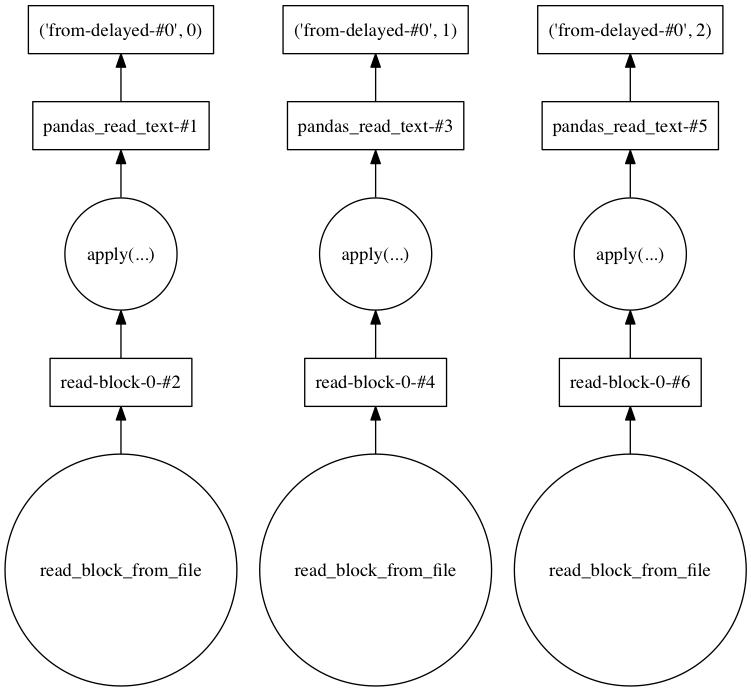

In [8]:
# try changing the expression and visualize the generated graph
df.visualize()

## How does this compare to Pandas?

### Features and Size

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then you should use Pandas.  The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial we provide a small dataset consisting of a few CSV files.  This dataset is 45MB on disk that expands to about 400MB in memory (the difference is caused by using `object` dtype for strings).  This dataset is small enough that you would normally use Pandas.

We've chosen this size so that exercises finish quickly.  Dask.dataframe only really becomes meaningful for problems significantly larger than this, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler allows the same dataframe expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node (e.g., amazon's S3), and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.

### Speed

Dask.dataframe operations use `pandas` operations internally.  Generally they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task.  This is usually negligible.
2.  When Pandas releases the GIL (coming to `groupby` in the next version) `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

### Exercise: Recall and use Pandas API

If you are already familiar with the Pandas API then you should have a firm grasp on how to use `dask.dataframe`.  There are a couple of small changes.

As noted above, computations on dask `DataFrame` objects don't perform work, instead they build up a dask graph.  We can evaluate this dask graph at any time using the `.compute()` method.

In [10]:
result = df.amount.mean()  # create lazily evaluated result
result

dd.Scalar<series-..., dtype=float64>

In [11]:
result.compute()           # perform actual computation

935.2060576666667

**Aside:** Calling `compute()` caused the execution of the whole graph, returned the value, and then freed up the associated resources. This is normal execution, which leaved all memory available for whatever is next. If we had called `client.compute(result)`, this would have given us a *future*, and instantly returned - the only advantage being that we can do other work while the cluster performs its actions, and we keep a handle to the result (which is cached while the future lives). In order to avoid going through the CSV load every time, we can *persist* the loaded dataframe into the cluster memory - if the cluster has enough memory. This is a very typical step for load-once, query-often data:
```python
df = client.persist(df)
```

Try the following exercises

1.  Use the `head()` method to get the first ten rows
2.  Use the `drop_duplicates()` method to find all of the distinct names
3.  Use selections `df[...]` to find how many positive and negative amounts there are
4.  Use groupby `df.groupby(df.A).B.func()` to get the average amount per user ID
5.  Sort the result to (4) by amount, find the names of the top 10 

This section should be easy if you are familiar with Pandas.  If you aren't then that's ok too.  You may find the [pandas documenation](http://pandas.pydata.org/) a useful read in the future.  Don't worry, future sections in this tutorial will not depend on this knowledge.

In [12]:
# 1. Use the `head()` method to get the first ten rows
#    Note, head computes by default, this is the only operation that doesn't need an explicit call to .compute()
df.head()

,id,names,amount
0,95,George,1932
1,467,Victor,273
2,461,Wendy,409
3,327,Michael,-145
4,167,Bob,225


In [13]:
# 2. Use the `drop_duplicates()` method to find all of the distinct names


In [14]:
# 3. Use selections `df[...]` to find how many positive and negative amounts there are


In [15]:
# 3. Use selections `df[...]` to find how many positive and negative amounts there are


In [16]:
# 4. Use groupby `df.groupby(df.A).B.func()` to get the average amount per user ID 


In [17]:
# 5. Combine your answers to 3 and 4 to compute the average withdrawal (negative amount) per name


In [ ]:
# %load solutions/DataFrame-01.py
# 1. Use the `head()` method to get the first ten rows
df.head()

# 2. Use the `drop_duplicates()` method to find all of the distinct names
df.names.drop_duplicates().compute()

# 3. Use selections `df[...]` to find how many positive and negative amounts
# there are
len(df[df.amount < 0])

# 3. Use selections `df[...]` to find how many positive and negative amounts
# there are
len(df[df.amount > 0])

# 4. Use groupby `df.groupby(df.A).B.func()` to get the average amount per user
# ID
df.groupby(df.names).amount.mean().compute()

# 5. Combine your answers to 3 and 4 to compute the average withdrawal
# (negative amount) per name
df2 = df[df.amount < 0]
df2.groupby(df2.names).amount.mean().compute()


<img src="images/dask-dataframe.svg" align="right" width="40%">

Divisions and the Index
---------------------------

The Pandas index associates a value to each record/row of your data.  Operations that align with the index, like `loc` can be a bit faster as a result.

In `dask.dataframe` this index becomes even more important.  Recall that one dask `DataFrame` consists of several Pandas `DataFrame`s.  These dataframes are separated along the index by value.  For example, when working with time series we may partition our large dataset by month.

Recall that these many partitions of our data may not all live in memory at the same time, instead they might live on disk; we simply have tasks that can materialize these pandas `DataFrames` on demand.

Partitioning your data can greatly improve efficiency.  Operations like `loc`, `groupby`, and `merge/join` along the index are *much more efficient* than operations along other columns.  You can see how your dataset is partitioned with the `.divisions` attribute.  Note that data that comes out of simple data sources like CSV files aren't intelligently indexed by default.  In these cases the values for `.divisions` will be `None.`

In [19]:
df = dd.read_csv(filename)
df.divisions

(None, None, None, None)

However if we set the index to some new column then dask will divide our data roughly evenly along that column and create new divisions for us.  Warning, `set_index` triggers immediate computation.

In [20]:
df2 = df.set_index('names')
df2.divisions

('Alice', 'Hannah', 'Patricia', 'Zelda')

We see here the minimum and maximum values ("Alice" and "Zelda") as well as two intermediate values that separate our data well.  This dataset has three partitions.

**Aside:** immediately after expensive operations such as set_index would also be a good time to use `client.persist` if the cluster has enough memory.

In [21]:
df2.npartitions

3

In [22]:
df2.head()

,id,amount
names,,
Alice,196,2179
Alice,34,900
Alice,215,-27
Alice,155,47
Alice,401,1089


Operations like `loc` only need to load the relevant partitions

In [23]:
df2.loc['Edith']

,id,amount
npartitions=1,,
Edith,int64,int64
Edith,...,...


In [24]:
df2.loc['Edith'].compute()

,id,amount
names,,
Edith,462,-72
Edith,489,501
Edith,51,643
Edith,51,679
Edith,181,-28
Edith,139,1020
Edith,416,111
Edith,416,75
Edith,181,-14


### Exercise

Make a new dataframe that sets the index to the `id` column.  Use `loc` to collect the records with the 100th id.

In [ ]:
# %load solutions/DataFrame-02.py
df2 = df.set_index('id')
print(df2.loc[100])


## Limitations

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial inter-process communication and may write out to disk.

Finally, `dask.dataframe` is quite new and non-trivial bugs are frequently reported (and quickly fixed).

### What definitely works?

* Trivially parallelizable operations (fast):
    *  Elementwise operations:  ``df.x + df.y``
    *  Row-wise selections:  ``df[df.x > 0]``
    *  Loc:  ``df.loc[4.0:10.5]``
    *  Common aggregations:  ``df.x.max()``
    *  Is in:  ``df[df.x.isin([1, 2, 3])]``
    *  Datetime/string accessors:  ``df.timestamp.month``
* Cleverly parallelizable operations (also fast):
    *  groupby-aggregate (with common aggregations): ``df.groupby(df.x).y.max()``
    *  value_counts:  ``df.x.value_counts``
    *  Drop duplicates:  ``df.x.drop_duplicates()``
    *  Join on index:  ``dd.merge(df1, df2, left_index=True, right_index=True)``
* Operations requiring a shuffle (slow-ish, unless on index)
    *  Set index:  ``df.set_index(df.x)``
    *  groupby-apply (with anything):  ``df.groupby(df.x).apply(myfunc)``
    *  Join not on the index:  ``pd.merge(df1, df2, on='name')``
* Ingest operations
    *  CSVs: ``dd.read_csv``
    *  Pandas: ``dd.from_pandas``
    *  Anything supporting numpy slicing: ``dd.from_array``
    *  From any set of functions creating sub dataframes via ``dd.from_delayed``.
    *  Dask.bag: ``mybag.to_dataframe(columns=[...])``